## 颠覆性

In [1]:
# -*- coding: utf-8 -*-
"""
期刊颠覆性指数分析系统
"""

# === 基础库 ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import warnings
import json
# === 第三方工具 ===
import ast
from sqlalchemy import create_engine

# === 设置 ===
warnings.filterwarnings('ignore')
plt.rcParams['font.sans-serif'] = ['SimHei']  # 中文字体支持
plt.rcParams['axes.unicode_minus'] = False   # 正常显示负号
import os

# === 在 notebook 第一个代码单元格中执行 ===
# 获取当前工作目录（通常是 notebooks/）
CURRENT_DIR = os.getcwd()
print("当前工作目录:", CURRENT_DIR)

# 推断项目根目录：假设 notebooks 是子目录
PROJECT_ROOT = os.path.abspath(os.path.join(CURRENT_DIR, '..'))

print("项目根目录:", PROJECT_ROOT)

# 定义输出目录
OUTPUT_DIR = os.path.join(PROJECT_ROOT, 'outputs', 'disrupt')
os.makedirs(OUTPUT_DIR, exist_ok=True)

# 定义数据路径
DATA_DIR = os.path.join(PROJECT_ROOT, 'data', 'raw')

print("数据目录:", DATA_DIR)
print("输出目录:", OUTPUT_DIR)


当前工作目录: c:\Users\28623\OneDrive\Desktop\BankJournalAnalysis\notebooks
项目根目录: c:\Users\28623\OneDrive\Desktop\BankJournalAnalysis
数据目录: c:\Users\28623\OneDrive\Desktop\BankJournalAnalysis\data\raw
输出目录: c:\Users\28623\OneDrive\Desktop\BankJournalAnalysis\outputs\disrupt


In [2]:
df_all = pd.read_csv(os.path.join(DATA_DIR, 'data_with_citing.csv'))
df_top10 = pd.read_csv(os.path.join(DATA_DIR, 'top10_journals_data.csv'))


In [3]:
class DisruptionIndexCalculator:
    """
    颠覆性指数计算器（基于 Wu et al., Nature 2019）
    """
    def __init__(self):
        self.citation_network = defaultdict(set)  # cited -> {citing}
        self.paper_references = {}               # paper_id -> {refs}

    def build_citation_network(self, df):
        """构建全局引文网络"""
        print("🔄 正在构建引文网络...")
        for _, row in df.iterrows():
            paper_id = row['DOI']
            citing_str = row.get('citing', None)
            
            refs = set()
            if pd.notna(citing_str):
                try:
                    if isinstance(citing_str, str):
                        refs = set(ast.literal_eval(citing_str))
                    else:
                        refs = set(citing_str)
                except (ValueError, SyntaxError):
                    pass  # 解析失败则留空
            
            self.paper_references[paper_id] = refs
            for ref in refs:
                self.citation_network[ref].add(paper_id)
        
        print(f"✅ 引文网络构建完成 | 涉及论文数: {len(df)}")
        return self

    def calculate_disruption_index(self, focal_paper_id):
        """计算单篇论文的 D-index"""
        R = self.paper_references.get(focal_paper_id, set())  # 参考文献
        C = self.citation_network.get(focal_paper_id, set())  # 施引文献
        
        ni = nj = nk = 0
        
        # ni: 引FP但不引R；nj: 同时引FP和R
        for citing_paper in C:
            citing_refs = self.paper_references.get(citing_paper, set())
            if citing_refs & R:
                nj += 1
            else:
                ni += 1
        
        # nk: 引R但不引FP
        papers_citing_R = set()
        for r in R:
            papers_citing_R.update(self.citation_network.get(r, set()))
        nk = len(papers_citing_R - C)
        
        denom = ni + nj + nk
        d_index = (ni - nj) / denom if denom > 0 else 0.0
        return d_index, (ni, nj, nk)

# ========== 新增：导出引文网络 ==========
def export_citation_network(calculator, paper_scores_df, output_file=None):
    """
    导出引文网络，默认输出到 outputs/disrupt/citation_network.json（基于项目结构自动推导）
    """
    if output_file is None:
        # 推导项目根目录
        try:
            current_dir = os.path.dirname(__file__)
        except NameError:
            current_dir = os.getcwd()
        project_root = os.path.abspath(os.path.join(current_dir, '..'))
        output_file = os.path.join(project_root, 'outputs', 'disrupt', 'citation_network.json')

    # 后续逻辑不变...
    print("📦 正在导出带 D-index 的引文网络...")

    edges = []
    for cited_doi, citing_set in calculator.citation_network.items():
        for citing_doi in citing_set:
            edges.append({'source': cited_doi, 'target': citing_doi})

    d_index_series = paper_scores_df.set_index('DOI')['disruption_index']
    d_index_map = {doi: None if pd.isna(val) else val for doi, val in d_index_series.items()}

    nodes = [
        {
            'id': paper_id,
            'type': 'paper',
            'n_references': len(refs),
            'disruption_index': d_index_map.get(paper_id, None)
        }
        for paper_id, refs in calculator.paper_references.items()
    ]

    graph_data = {'nodes': nodes, 'edges': edges}
    os.makedirs(os.path.dirname(output_file), exist_ok=True)

    with open(output_file, 'w', encoding='utf-8') as f:
        json.dump(graph_data, f, ensure_ascii=False, indent=2)

    print(f"✅ 成功导出引文网络：共 {len(nodes)} 个节点，{len(edges)} 条边")
    print(f"📁 文件已保存至: {output_file}")


def calculate_paper_disruption_scores(df_background, df_target):
    """
    主函数：为 df_target 中的每篇论文计算 D-index
    返回结果表 和 构建好的计算器（用于后续导出网络）
    """
    calc = DisruptionIndexCalculator().build_citation_network(df_background)
    
    results = []
    total = len(df_target)
    progress_checkpoint = 0

    print("📊 开始计算论文颠覆性指数...")
    for i, (_, row) in enumerate(df_target.iterrows()):
        doi = row['DOI']
        try:
            d_index, _ = calc.calculate_disruption_index(doi)
            results.append({'DOI': doi, 'disruption_index': d_index})
        except Exception as e:
            results.append({'DOI': doi, 'disruption_index': np.nan})

        current_progress = (i + 1) / total
        if current_progress >= progress_checkpoint:
            print(f"✅ 进度: {int(progress_checkpoint * 100)}%", end="\r")
            progress_checkpoint += 0.1

    print("\n🎉 计算完成！")
    result_df = pd.DataFrame(results)
    final_df = result_df.merge(df_target[['DOI', 'Source Title']], on='DOI', how='left')
    
    #  新增：同时返回结果 和 计算器
    return final_df, calc


In [4]:
# 执行计算（现在返回两个值）
paper_disruption_scores, calculator = calculate_paper_disruption_scores(df_all, df_top10)

# 导出带 D-index 的网络
export_citation_network(
    calculator,
    paper_scores_df=paper_disruption_scores,
    output_file=os.path.join(OUTPUT_DIR, 'citation_network.json')  # 关键！
)



🔄 正在构建引文网络...
✅ 引文网络构建完成 | 涉及论文数: 13709
📊 开始计算论文颠覆性指数...
✅ 进度: 99%
🎉 计算完成！
📦 正在导出带 D-index 的引文网络...
✅ 成功导出引文网络：共 12552 个节点，406233 条边
📁 文件已保存至: c:\Users\28623\OneDrive\Desktop\BankJournalAnalysis\outputs\disrupt\citation_network.json


In [5]:
def calculate_original_metrics(df):
    """原始方法：所有论文平均 D-index"""
    return (df.groupby('Source Title')
              .agg({'disruption_index': 'mean', 'DOI': 'count'})
              .rename(columns={'disruption_index': 'disruption_mean', 'DOI': 'paper_count'})
              .sort_values('disruption_mean', ascending=False)
              .reset_index())

def calculate_enhanced_metrics(df, top_k=10, volume_weight=0.4):
    """增强方法：Top-k 平均 + 规模加权"""
    valid = df.dropna(subset=['disruption_index'])
    grouped = valid.groupby('Source Title')
    
    records = []
    for journal, group in grouped:
        n_papers = len(group)
        k = min(top_k, n_papers)
        top_avg = group.nlargest(k, 'disruption_index')['disruption_index'].mean()
        log_n = np.log1p(n_papers)
        # 原来是：(1-w) * top_avg + w * (log_n * top_avg)  → 放大得分
        score = (1 - volume_weight) * top_avg + volume_weight * (top_avg / log_n)

        records.append({
            'Source Title': journal,
            'n_papers': n_papers,
            'top_k_mean': top_avg,
            'enhanced_disruption': score
        })
    
    return pd.DataFrame(records).sort_values('enhanced_disruption', ascending=False).reset_index(drop=True)

# === 生成两套指标 ===
original_metrics = calculate_original_metrics(paper_disruption_scores)
enhanced_metrics = calculate_enhanced_metrics(paper_disruption_scores, top_k=10, volume_weight=0.4)


In [6]:
def visualize_journal_ranking(journal_metrics, top_n=None, title=None, value_col='disruption_mean'):
    """
    通用期刊排名可视化
    支持不同列名和标题
    """
    data = journal_metrics.head(top_n) if top_n is not None else journal_metrics.copy()
    
    plt.figure(figsize=(14, max(8, len(data) * 0.4)))
    colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(data)))

    bars = plt.barh(
        data['Source Title'],
        data[value_col],
        color=colors,
        alpha=0.8,
        edgecolor='black',
        linewidth=0.5,
        height=0.7
    )

    max_val = data[value_col].max()
    text_x = max_val * 1.08

    for bar, val in zip(bars, data[value_col]):
        plt.text(text_x, bar.get_y() + bar.get_height()/2,
                 f'{val:.4f}', ha='left', va='center', fontsize=10,
                 bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8, edgecolor='gray'))

    plt.xlabel("颠覆性指数", fontsize=13, fontweight='bold')
    plt.ylabel("期刊名称", fontsize=13, fontweight='bold')
    plt.title(title or "期刊颠覆性指数排名", fontsize=16, fontweight='bold', pad=20)

    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(0.5)
    ax.spines['bottom'].set_linewidth(0.5)
    ax.grid(axis='x', linestyle='--', alpha=0.3, color='gray')
    ax.set_facecolor('#f8f9fa')
    plt.gcf().patch.set_facecolor('white')
    ax.invert_yaxis()
    plt.tight_layout()
    plt.show()


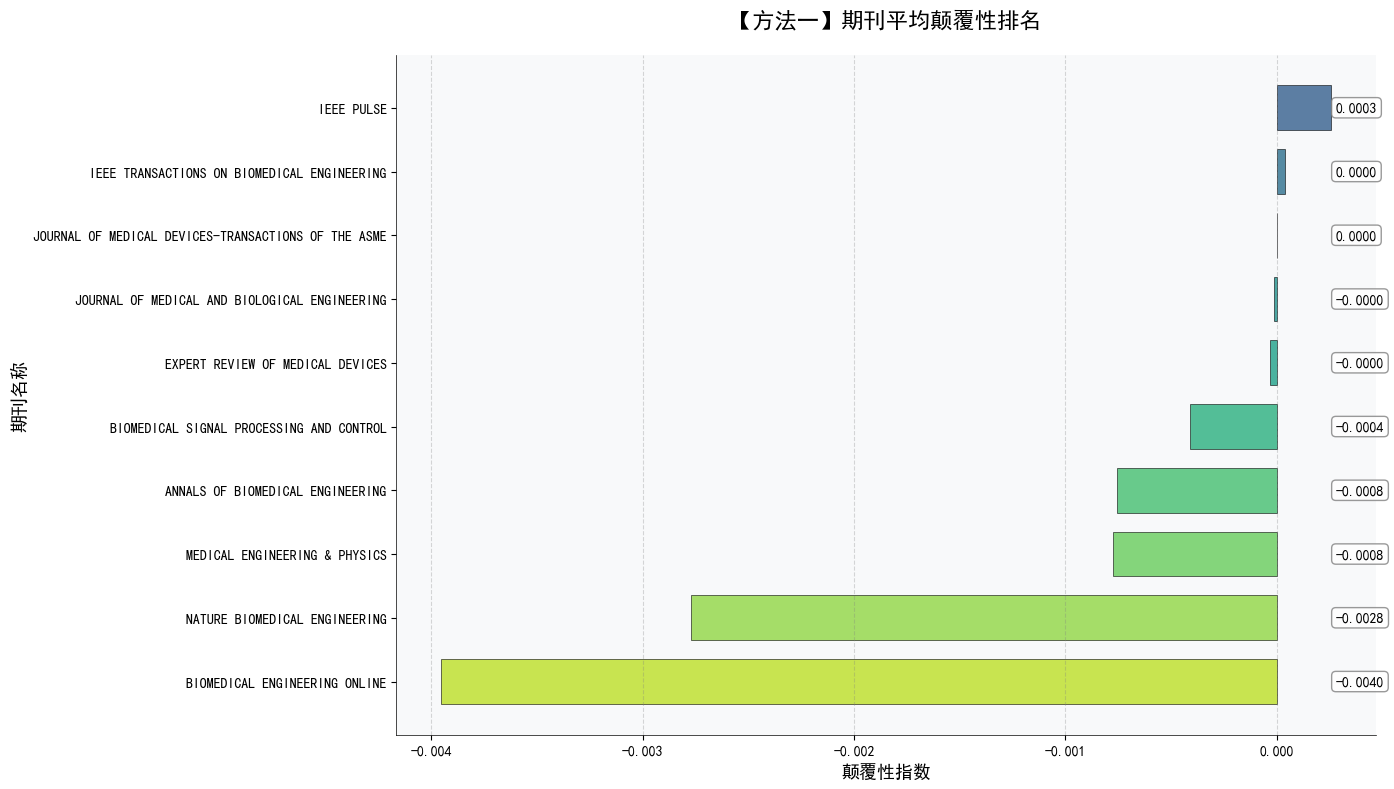

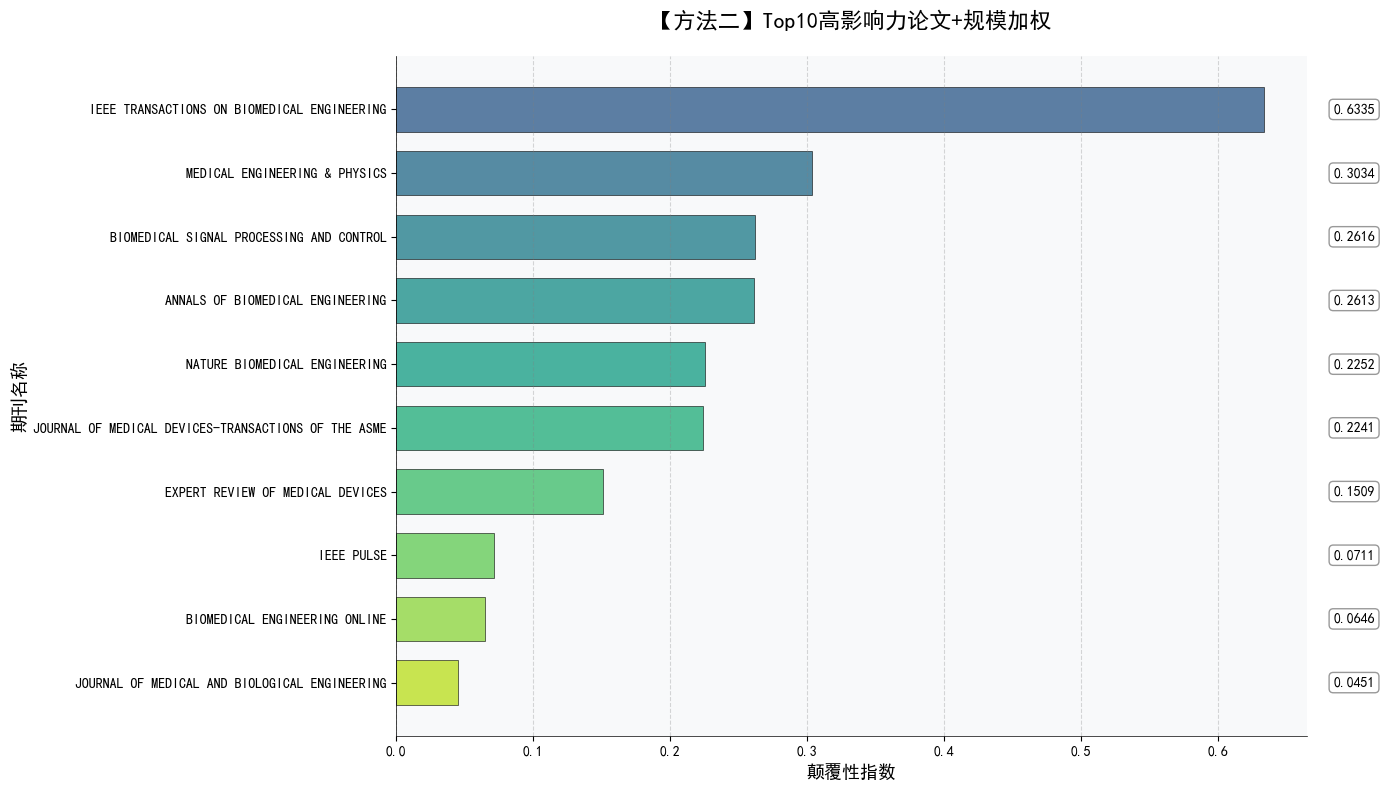

In [7]:
# 图1：原始方法
visualize_journal_ranking(
    original_metrics,
    top_n=10,
    title="【方法一】期刊平均颠覆性排名",
    value_col='disruption_mean'
)

# 图2：增强方法
visualize_journal_ranking(
    enhanced_metrics,
    top_n=10,
    title="【方法二】Top10高影响力论文+规模加权",
    value_col='enhanced_disruption'
)
